# 自定义训练实战(非tf.keras)

## 导入相关库

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import matplotlib.pyplot as plt

import tensorflow as tf
print('tf version:', tf.__version__)
print('eager execution:', tf.executing_eagerly())

tf version: 2.0.0-rc0
eager execution: True


## 鸢尾花分类问题

下载数据集 使用tf.keras.utils.get_file函数下载训练数据集文件。 这将返回下载文件的文件路径。

In [3]:
train_dataset_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv"
train_dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url), origin=train_dataset_url)

print('下载数据至：', train_dataset_fp)

8192/2194 [================================================================================================================] - 0s 0us/step
下载数据至： /Users/momo/.keras/datasets/iris_training.csv


## 检查数据

In [4]:
! head -n5 {train_dataset_fp}

120,4,setosa,versicolor,virginica
6.4,2.8,5.6,2.2,2
5.0,2.3,3.3,1.0,1
4.9,2.5,4.5,1.7,2
4.9,3.1,1.5,0.1,0


第一行是包含有关数据集的信息的标题： 总共有120个例子。 每个示例都有四个特征和三个可能的标签名称之一。 后续行是数据记录，每行一个示例，其中： 前四个字段是特征：这些是示例的特征。 这里，字段包含代表花卉测量值的浮点数。 最后一列是标签：这是我们想要预测的值。 对于此数据集，它是与花名称对应的整数值0,1或2。

In [5]:
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
# 获取特征和标签名
feature_name = column_names[:-1]
label_name = column_names[-1]

每个标签都与字符串名称相关联（例如，“setosa”），但机器学习通常依赖于数值。使用标签数字来映射类别，例如：
- 0：Iris setosa:
- 1：Iris versicolor
- 2：Iris virginica

In [6]:
class_names = ['Iris setosa', 'Iris versicolor', 'Iris virginica']

## 创建一个 tf.data.Dataset

TensorFlow的数据集API处理许多将数据加载到模型中的常见情况。这是一个高级API，用于读取数据并将其转换为用于训练的数据类型。

由于数据集是CSV格式的文本文件，因此需要使用make_csv_dataset函数将数据解析为合适的格式。由于此函数为训练模型生成数据，因此默认行为是对数据（shuffle=True, shuffle_buffer_size=10000）进行混洗，并永远重复数据集（num_epochs=None）。同时还需要设置batch_size参数。

In [7]:
batch_size=32
train_dataset = tf.data.experimental.make_csv_dataset(
    train_dataset_fp,
    batch_size,
    column_names=column_names,
    label_name=label_name,
    num_epochs=1
)

W0925 10:15:08.905879 140735707075456 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow_core/python/data/experimental/ops/readers.py:521: parallel_interleave (from tensorflow.python.data.experimental.ops.interleave_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_determinstic`.


该make_csv_dataset函数返回tf.data.Dataset的(features, label)对，其中features是一个字典：{'feature_name': value}

而这些Dataset对象是可迭代的。

In [8]:
features, labels = next(iter(train_dataset))
print(features)

OrderedDict([('sepal_length', <tf.Tensor: id=69, shape=(32,), dtype=float32, numpy=
array([4.7, 6.5, 5.2, 6.2, 4.6, 7.7, 5. , 5.7, 5.5, 5.4, 4.8, 6.8, 6.9,
       5.9, 5. , 7.2, 6. , 6.1, 4.6, 5.7, 6. , 5. , 6. , 6.9, 6.3, 6.4,
       5. , 4.7, 6.3, 6. , 7.7, 4.9], dtype=float32)>), ('sepal_width', <tf.Tensor: id=70, shape=(32,), dtype=float32, numpy=
array([3.2, 3. , 2.7, 3.4, 3.2, 2.6, 2.3, 2.8, 2.4, 3.4, 3.1, 3. , 3.1,
       3.2, 3.2, 3.6, 2.2, 3. , 3.6, 2.9, 2.9, 3.4, 3. , 3.1, 3.3, 2.8,
       3. , 3.2, 2.3, 2.7, 3.8, 2.5], dtype=float32)>), ('petal_length', <tf.Tensor: id=67, shape=(32,), dtype=float32, numpy=
array([1.6, 5.8, 3.9, 5.4, 1.4, 6.9, 3.3, 4.5, 3.8, 1.5, 1.6, 5.5, 4.9,
       4.8, 1.2, 6.1, 5. , 4.9, 1. , 4.2, 4.5, 1.5, 4.8, 5.1, 6. , 5.6,
       1.6, 1.3, 4.4, 5.1, 6.7, 4.5], dtype=float32)>), ('petal_width', <tf.Tensor: id=68, shape=(32,), dtype=float32, numpy=
array([0.2, 2.2, 1.4, 2.3, 0.2, 2.3, 1. , 1.3, 1.1, 0.4, 0.2, 2.1, 1.5,
       1.8, 0.2, 2.5, 1.5, 1.8, 0

相同的特征被放在同一个数组中，数组维度为batch_size大小。 可以可视化如图：

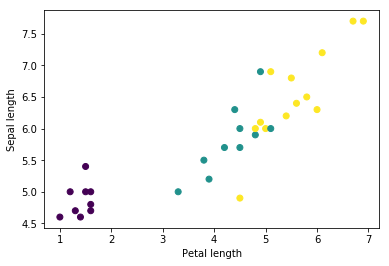

In [9]:
%matplotlib inline
plt.scatter(features['petal_length'],
            features['sepal_length'],
            c=labels,
            cmap='viridis')

plt.xlabel("Petal length")
plt.ylabel("Sepal length")
plt.show()

一般我们会把同一个数据的不同feature放在同一个数组中，我们使用tf.pack()來将features重构为(batch_size, num_features)形状。

In [10]:
def pack_features_vector(features, labels):
    features = tf.stack(list(features.values()), axis=1)
    return features, labels

# 使用tf.data.Dataset.map将重构函数运用到每条数据中。
train_dataset = train_dataset.map(pack_features_vector)
# 查看前5个数据
features, labels = next(iter(train_dataset))
print(features[:5])

tf.Tensor(
[[4.9 3.1 1.5 0.1]
 [6.  2.2 5.  1.5]
 [6.8 3.2 5.9 2.3]
 [6.1 2.9 4.7 1.4]
 [5.1 3.8 1.6 0.2]], shape=(5, 4), dtype=float32)


## 选择模型

## 使用Keras创建模型

TensorFlow tf.keras API是创建模型和图层的首选方式。这使得构建模型和实验变得容易，而Keras处理将所有内容连接在一起的复杂性。

该tf.keras.Sequential模型是层的线性堆栈。它的构造函数采用一个层实例列表，在这种情况下，两个Dense层各有10个节点，一个输出层有3个节点代表我们的标签预测。第一层的input_shape参数对应于数据集中的要素数，并且是必需的。

In [11]:
# 构建线性模型
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu',input_shape=(4,)),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(3)
])

## 测试模型结构

In [12]:
prediction = model(features)
prediction[:5]

<tf.Tensor: id=232, shape=(5, 3), dtype=float32, numpy=
array([[-0.5871249 , -0.80793786, -0.0621177 ],
       [-1.281161  , -1.1702746 , -1.0981395 ],
       [-1.4373012 , -1.4070221 , -1.1877819 ],
       [-1.134388  , -1.2376039 , -0.92081964],
       [-0.47654083, -0.9616532 ,  0.10862815]], dtype=float32)>

多分类任务需要使用softmax进行归一化

In [13]:
tf.nn.softmax(prediction)[:5]

<tf.Tensor: id=237, shape=(5, 3), dtype=float32, numpy=
array([[0.28634116, 0.2296074 , 0.4840514 ],
       [0.30137655, 0.33671835, 0.36190507],
       [0.30173647, 0.31101248, 0.38725108],
       [0.31846932, 0.2872377 , 0.39429304],
       [0.29317582, 0.18048726, 0.5263369 ]], dtype=float32)>

使用tf.argmax获取概率最大的类标签

In [14]:
print('prediction:', tf.argmax(prediction, axis=1))
print('label:', labels)

prediction: tf.Tensor([2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2], shape=(32,), dtype=int64)
label: tf.Tensor([0 2 2 1 0 2 2 2 1 0 1 2 1 0 0 1 1 2 0 0 0 0 0 1 0 1 2 1 1 2 0 1], shape=(32,), dtype=int32)


## 训练模型

训练和评估的过程都需要计算模型的损失，它可以衡量预测与正确标签的差距，训练过程都是要最小化损失。

我们后面将直接使用tf.keras里面包装好的损失函数来计算损失。

In [15]:
# 损失函数
loss_object=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# 获取损失
def loss(model, x, y):
    y_ = model(x)
    return loss_object(y_true=y, y_pred=y_)
l = loss(model, features, labels)
print(l)

tf.Tensor(1.169647, shape=(), dtype=float32)


使用tf.GradientTape计算loss对所有变量的梯度。

In [16]:
def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

## 创建优化器

优化程序将计算出的梯度应用于模型的变量，以最大限度地减少损失函数。 您可以将损失函数视为曲面（参见图3），我们希望通过四处走动找到它的最低点。 渐变指向最陡的上升方向 - 所以我们将以相反的方向行进并向下移动。 通过迭代计算每批的损失和梯度，我们将在训练期间调整模型。 逐渐地，该模型将找到权重和偏差的最佳组合，以最小化损失。 损失越低，模型的预测越好。

TensorFlow有许多可用于训练的优化算法。 该模型使用tf.train.GradientDescentOptimizer实现随机梯度下降（SGD）算法。 learning_rate设置每次迭代下一步的步长。 这是一个超参数，您通常会调整以获得更好的结果。

In [17]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [18]:
loss_value, grads = grad(model, features, labels)
print('步数：{}, 初始loss值：{}'.format(optimizer.iterations.numpy(),
                                loss_value.numpy()))
optimizer.apply_gradients(zip(grads, model.trainable_variables))
print('步数：{}, loss值：{}'.format(optimizer.iterations.numpy(),
                                loss(model,features, labels).numpy()))

步数：0, 初始loss值：1.169646978378296
步数：1, loss值：1.1170145273208618


## 训练循环

In [19]:
# 保存loss和acc
train_loss_results=[]
train_accuracy_results=[]

num_epochs =201
for epoch in range(num_epochs):
    # 用于记录loss和acc的类
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

    # 训练循环
    for x, y in train_dataset:
        # 获取loss和梯度
        loss_value, grads = grad(model, x, y)
        # 梯度优化
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # 记录loss均值
        epoch_loss_avg(loss_value)
        # 记录准确率
        epoch_accuracy(y, model(x))

    # 保存每个epoch的loss和acc
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())

    if epoch % 50 == 0:
        print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                    epoch_loss_avg.result(),
                                                                    epoch_accuracy.result()))

Epoch 000: Loss: 1.081, Accuracy: 28.333%
Epoch 050: Loss: 0.107, Accuracy: 97.500%
Epoch 100: Loss: 0.056, Accuracy: 99.167%
Epoch 150: Loss: 0.043, Accuracy: 98.333%
Epoch 200: Loss: 0.041, Accuracy: 98.333%


## 可视化训练过程

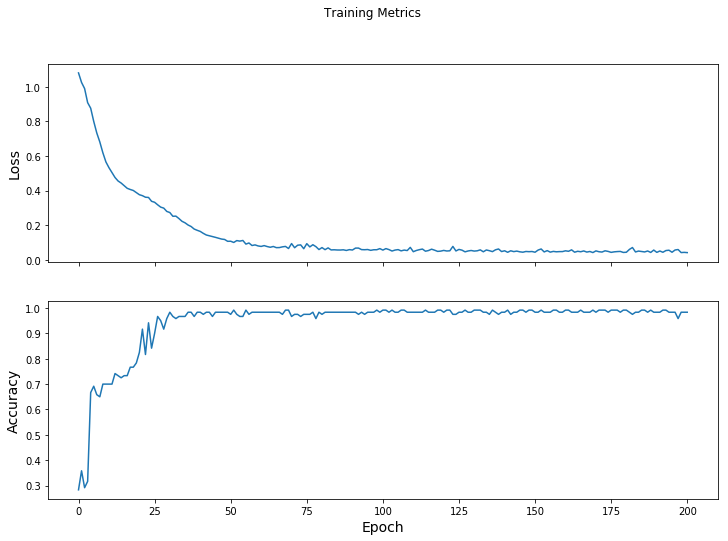

In [20]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

## 评估模型

In [21]:
test_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv"

test_fp = tf.keras.utils.get_file(fname=os.path.basename(test_url),
                                  origin=test_url)

8192/573 [============================================================================================================================================================================================================================================================================================================================================================================================================================================] - 0s 0us/step


In [22]:
test_dataset = tf.data.experimental.make_csv_dataset(
    test_fp,
    batch_size,
    column_names=column_names,
    label_name='species',
    num_epochs=1,
    shuffle=False)

test_dataset = test_dataset.map(pack_features_vector)

In [23]:
# 准确率统计类
test_accuracy = tf.keras.metrics.Accuracy()

for (x,y) in test_dataset:
    logits = model(x)
    prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
    test_accuracy(prediction, y) 

print('测试集准确率：', test_accuracy.result())

测试集准确率： tf.Tensor(0.96666664, shape=(), dtype=float32)


In [24]:
tf.stack([y, prediction], axis=1)

<tf.Tensor: id=113053, shape=(30, 2), dtype=int32, numpy=
array([[1, 1],
       [2, 2],
       [0, 0],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 0],
       [2, 1],
       [1, 1],
       [2, 2],
       [2, 2],
       [0, 0],
       [2, 2],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [0, 0],
       [0, 0],
       [2, 2],
       [0, 0],
       [1, 1],
       [2, 2],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [2, 2],
       [1, 1]], dtype=int32)>

## 使用训练的模型进行预测

In [25]:
predict_dataset = tf.convert_to_tensor([
    [5.1, 3.3, 1.7, 0.5,],
    [5.9, 3.0, 4.2, 1.5,],
    [6.9, 3.1, 5.4, 2.1]
])

predictions = model(predict_dataset)

for i, logits in enumerate(predictions):
    class_idx = tf.argmax(logits).numpy()
    p = tf.nn.softmax(logits)[class_idx]
    name = class_names[class_idx]
    print("Example {} prediction: {} ({:4.1f}%)".format(i, name, 100*p))

Example 0 prediction: Iris setosa (99.9%)
Example 1 prediction: Iris versicolor (99.9%)
Example 2 prediction: Iris virginica (99.0%)
